In [1]:
%load_ext autoreload
%autoreload 2
import warnings 
warnings.filterwarnings("ignore")

In [7]:
from qiskit_metal import designs, MetalGUI
from qiskit_metal.qlibrary.sample_shapes.rectangle import Rectangle
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.qubits.Transmon_Interdigitated import TransmonInterdigitated
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.designs.design_planar import DesignPlanar
import pandas as pd


# Main Design

In [9]:
design = DesignPlanar({},overwrite_enabled = True)

gui = MetalGUI(design)

## Qubit Design

In [10]:
design.delete_all_components()

#### Design so Resonator is coupled strongly to each qubit-> large cap leads to large dispersive shift
#####  larger dispersive shift results in better measurment, but also poorer anharminicity

conn_pads1 = dict(connection_pads = dict(coupler = dict(loc_W=1, loc_H=1, pad_width = '100um'),
                                         readout = dict(loc_W=-1, loc_H=-1, pad_width = '150um')))

conn_pads2 = dict(pad_width = '550um',
                  connection_pads = dict(coupler = dict(loc_W = -1, loc_H = 1,pad_width = '175um'),
                                         readout = dict(loc_W=1, loc_H=-1, pad_width='200um')))
q1 = TransmonPocket(design, "Q1", options=dict(pos_x='-0.5mm', pos_y='+0.0mm', layer=1, **conn_pads1))
q2 = TransmonPocket(design, "Q2", options=dict(pos_x='+0.5mm', pos_y='+0.0mm', layer=1, **conn_pads2))

gui.rebuild()
gui.autoscale()

## Coupler Design

In [11]:
coupler_options = dict(pin_inputs = dict(start_pin = dict(component=q2.name, pin='coupler'),
                                         end_pin = dict(component=q1.name, pin='coupler')))

coupler_connector = RouteStraight(design, 'coupler_connector', options = coupler_options)

gui.rebuild()
gui.autoscale()

## Readout Resonator Design

In [18]:
otg11_options = dict(pos_x='-1.5mm', pos_y = '0.0mm', orientation='180', layer='3')
otg21_options = dict(pos_x='+1.5mm', pos_y = '0.0mm', orientation='0', layer='3')
otg12_options = dict(pos_x='-0.955mm', pos_y = '-0.195mm', orientation='0', layer='3')
otg22_options = dict(pos_x='+0.955mm', pos_y = '-0.1955mm', orientation='180', layer='3')
otg11 = OpenToGround(design, 'otg11' ,options=otg11_options)
otg21 = OpenToGround(design, 'otg21' ,options=otg21_options)
otg12 = OpenToGround(design, 'otg12' ,options=otg12_options)
otg22 = OpenToGround(design, 'otg22' ,options=otg22_options)

readout1_options = dict(total_length = '5.97mm', fillet = '40um', 
                        pin_inputs = dict(start_pin = dict(component = otg11.name, pin='open'),
                                          end_pin = dict(component = otg12.name, pin = 'open')),
                        lead = dict(start_straight='150um'),
                        meander=dict(spacing = '100um', asymmetry = '0'),
                        layer = '3')

readout2_options = dict(total_length = '5.97mm', fillet = '40um', 
                        pin_inputs = dict(start_pin = dict(component = otg22.name, pin='open'),
                                          end_pin = dict(component = otg21.name, pin = 'open')),
                        lead = dict(start_straight='120um'),
                        meander=dict(spacing = '100um', asymmetry = '0.2'),
                        layer = '3')

readout1 = RouteMeander(design, 'readout1', options = readout1_options)
readout2 = RouteMeander(design, 'readout2', options = readout2_options)

gui.rebuild()
gui.autoscale()

## Via Creation and Dielectric

In [132]:
via_positions = [('-0.94mm','-0.1950mm'),('+0.94mm','-0.1950mm')]

for layer in ['1','2','3']:
    for via, positions in enumerate(via_positions):
        for subtract in zip([False,True],['30um','42um']):
            via_size = '20um' if layer =='2' else subtract[1]
            actual_layer = '5' if (layer == '2' and subtract[0]) else layer
            via_options = dict(width = via_size,
                               height = via_size,
                               pos_x = positions[0],
                               pos_y = positions[1],
                               subtract = subtract[0],
                               layer = actual_layer,
                               orientation = '0',
                               helper = 'False',
                               chip = 'main' )
            name = 'via' +str(via+1) +'_layer' + actual_layer+('' if not subtract[0] else '_sub')
            Rectangle(design, name, via_options)
            #print(subtract)
            #print(layer == '2' and subtract[0])
    
gui.rebuild()
gui.autoscale()
            

# Render and Extract Capacitance Matrix

In [133]:
from qiskit_metal.renderers.renderer_elmer.elmer_renderer import QElmerRenderer

## Render

In [134]:
#elmer_renderer = QElmerRenderer(design, layer_types = dict(metal = [1,2,3], dielectric = [4,5]))
#elmer_renderer.render_design(mesh_geoms = True,
#                             skip_junctions= False,
#                             open_pins=[("Q1","readout"),("Q2","readout")],
#                             omit_ground_for_layers = [2])
#elmer_renderer.launch_gmsh_gui()

## Generate Capacitance Matrix

In [135]:
#elmer_renderer.export_mesh()
#elmer_renderer.add_solution_setup('capacitance')
#elmer_renderer.run('capacitance')

In [136]:
#cap_matrix = elmer_renderer.capacitance_matrix
#cap_matrix.to_csv('cap_matrix.csv')

In [137]:
#elmer_renderer.display_post_processing_data()
#elmer_renderer.close()

In [138]:
elmer_renderer = QElmerRenderer(design, layer_types=dict(metal=[1,2,3], dielectric=[4,5]))
select = ['Q1','via1_layer1', 'via1_layer2', 'via1_layer3', 'via1_layer1_sub', 'via1_layer5_sub', 'via1_layer3_sub']
#select = ['Q1']
elmer_renderer.render_design(selection=select,  open_pins=[("Q1","readout"),("Q1","coupler")], skip_junctions=True, 
                            omit_ground_for_layers = [2])

#elmer_renderer.launch_gmsh_gui()

In [139]:
elmer_renderer.export_mesh()
elmer_renderer.add_solution_setup('capacitance')
elmer_renderer.run('capacitance')
cap_matrix_q1 = elmer_renderer.capacitance_matrix
cap_matrix_q1.to_csv('cap_matrix_q1.csv')
cap_matrix_q1


06:41PM 25s INFO [run]: Running ElmerGrid on input mesh from Gmsh...
06:41PM 27s INFO [run]: Running ElmerSolver for solver type: 'capacitance'


,Q1_coupler_connector_pad,via1_layer3_rectangle,Q1_pad_top,Q1_pad_bot,ground_plane
Q1_coupler_connector_pad,114.853611,-0.082688,-20.026697,-1.512614,-93.231612
via1_layer3_rectangle,-0.082688,183.681992,-2.025939,-27.548681,-154.024684
Q1_pad_top,-20.026697,-2.025939,237.539454,-51.705207,-163.781612
Q1_pad_bot,-1.512614,-27.548681,-51.705207,241.415283,-160.648782
ground_plane,-93.231612,-154.024684,-163.781612,-160.648782,300.000000


In [140]:
elmer_renderer = QElmerRenderer(design, layer_types=dict(metal=[1,2,3], dielectric=[4,5]))
select = ['Q2','via2_layer1', 'via2_layer2', 'via2_layer3', 'via2_layer1_sub', 'via2_layer5_sub', 'via2_layer3_sub']
#select = ['Q2']
elmer_renderer.render_design(selection=select,  open_pins=[("Q2","readout"),("Q2","coupler")], skip_junctions=True, 
                            omit_ground_for_layers = [2])

#elmer_renderer.launch_gmsh_gui()

In [141]:
elmer_renderer.export_mesh()
elmer_renderer.add_solution_setup('capacitance')
elmer_renderer.run('capacitance')
cap_matrix_q2 = elmer_renderer.capacitance_matrix
All_pass2 = elmer_renderer.c
cap_matrix_q2.to_csv('cap_matrix_q2.csv')
cap_matrix_q2


06:42PM 26s INFO [run]: Running ElmerGrid on input mesh from Gmsh...
06:42PM 27s INFO [run]: Running ElmerSolver for solver type: 'capacitance'


AttributeError: 'QElmerRenderer' object has no attribute 'c'

# LOM Analysis

# Time Evolution Simulation (Sequencing)

## Start here if kernal crashes

In [ ]:
import scqubits as scq
from scipy.constants import speed_of_light as c_light
import matplotlib.pyplot as plt
from qiskit_metal.analyses.quantization.lumped_capacitive import load_q3d_capacitance_matrix
from qiskit_metal.analyses.quantization.lom_core_analysis import CompositeSystem, Cell, Subsystem, QuantumSystemRegistry
import pandas as pd
from qiskit_metal.analyses.quantization import LOManalysis
from qiskit_metal.analyses.quantization.lumped_capacitive import *
import pandas as pd

cap_matrix_q1 = pd.read_csv('cap_matrix_q1.csv').set_index('Unnamed: 0',True)
cap_matrix_q1.index.name = None

cap_matrix_q2 = pd.read_csv('cap_matrix_q2.csv').set_index('Unnamed: 0',True)
cap_matrix_q2.index.name = None

l1 = 10            
c1 = 2
            
lj1 = l1*10**(-9)            
cj1  = c1*10**(-15)
opt1 = dict(node_rename = {'Q1_coupler_connector_pad':'coupling','via1_layer3_rectangle': 'readout_alice'},

            
#opt1 = dict(node_rename = {'Q1_coupler_connector_pad':'coupling','Q1_readout_connector_pad': 'readout_alice'},
            cap_mat = cap_matrix_q1,
            ind_dict = {('Q1_pad_top','Q1_pad_bot'):l1},
            jj_dict = {('Q1_pad_top','Q1_pad_bot'):'j1'},
            cj_dict = {('Q1_pad_top','Q1_pad_bot'):c1}
           )            

cell_1 = Cell(opt1)



l2 = 12            
c2 = 2
            
lj2 = l2*10**(-9)            
cj2  = c2*10**(-15)

opt2 = dict(node_rename = {'Q2_coupler_connector_pad':'coupling','via2_layer3_rectangle': 'readout_bob'},
#opt2 = dict(node_rename = {'Q2_coupler_connector_pad':'coupling','Q2_readout_connector_pad': 'readout_bob'},
            cap_mat = cap_matrix_q2,
            ind_dict = {('Q2_pad_top','Q2_pad_bot'):12},
            jj_dict = {('Q2_pad_top','Q2_pad_bot'):'j2'},
            cj_dict = {('Q2_pad_top','Q2_pad_bot'):2}
           )
cell_2 = Cell(opt2)

transmon_alice = Subsystem(name = 'transmon_alice', sys_type='TRANSMON', nodes=['j1'])

transmon_bob = Subsystem(name = 'transmon_bob', sys_type='TRANSMON', nodes=['j2'])


### Readout resonator properties

#Alice
q_opts1 = dict(
    f_res = 5.2, ##in GHz
    Z0 = 50,  #charicterisit impedance
    vp = 0.40314 * c_light, ## phase velocity
)
res_alice = Subsystem(name='readout_alice', sys_type ='TL_RESONATOR', nodes = ['readout_alice'], q_opts = q_opts1)


#Bob
q_opts2 = dict(
    f_res = 4.5, ##in GHz
    Z0 = 50,  #charicterisit impedance
    vp = 0.40314 * c_light, ## phase velocity
)
res_bob = Subsystem(name='readout_bob', sys_type ='TL_RESONATOR', nodes = ['readout_bob'], q_opts = q_opts2)



composite_sys = CompositeSystem(
            subsystems = [transmon_alice, transmon_bob, res_alice, res_bob],
            cells = [cell_1, cell_2],
            grd_node = 'ground_plane', #ID Ground plane to remove
            nodes_force_keep = ['readout_alice', 'readout_bob'] #need to do this so hamiltonian includes readout res's
            )

## Creats hilbert space for seqeuncing analysis
hilbertspace = composite_sys.create_hilbertspace()
hilbertspace = composite_sys.add_interaction()
hilbertspace.hamiltonian()



## Geting Transmon Properties

In [ ]:
##### Get Transmon properties
cap_matrix_q1 = pd.read_csv('cap_matrix_q1.csv').set_index('Unnamed: 0',True)
cap_matrix_q1.index.name = None

cap_matrix_q2 = pd.read_csv('cap_matrix_q2.csv').set_index('Unnamed: 0',True)
cap_matrix_q2.index.name = None

Ic1 = Ic_from_Lj(lj1)
Ic2 = Ic_from_Lj(lj2)
N = 2
fb1 = 4
fr1 = 5.2
fb2 = 4
fr2 = 5.2

cap_matrix_q1 = cap_matrix_q1[["Q1_coupler_connector_pad","ground_plane","Q1_pad_top",
                               "Q1_pad_bot","via1_layer3_rectangle"]]
cap_matrix_q1 = cap_matrix_q1.reindex(["Q1_coupler_connector_pad","ground_plane",
                                       "Q1_pad_top","Q1_pad_bot","via1_layer3_rectangle"]).to_numpy()
cap_matrix_q2 = cap_matrix_q2[["Q2_coupler_connector_pad","ground_plane","Q2_pad_top",
                               "Q2_pad_bot","via2_layer3_rectangle"]]
cap_matrix_q2 = cap_matrix_q2.reindex(["Q2_coupler_connector_pad","ground_plane",
                                       "Q2_pad_top","Q2_pad_bot","via2_layer3_rectangle"]).to_numpy()
Tmon1 = extract_transmon_coupled_Noscillator(cap_matrix_q1, Ic1,cj1,N,fb1,fr1,print_info = True)
#Tmon2 = extract_transmon_coupled_Noscillator(cap_matrix_q2, Ic2,cj2,N,fb2,fr2,print_info = True)



In [3]:
from tqdm import tqdm
from functools import partial
import qutip

from sequencing import Qubit, Transmon, Cavity, System, get_sequence, sync, delay, QasmSequence
from sequencing.calibration import fit_sine, fit_displacement, tune_rabi, tune_displacement, tune_drag

from qiskit_metal.analyses.quantization.lom_time_evolution_sim import lom_composite_sys_to_seq_sys

In [4]:
system = lom_composite_sys_to_seq_sys(composite_sys, hilbertspace, levels = [3,3,10,10])


In [5]:
system.modes #Mode is a subsystem in LOM analysis

[Transmon(name='transmon_bob', cls='sequencing.modes.Transmon', levels=3, t1=inf, t2=inf, thermal_population=0.0, df=0.0, kerr=-0.11741838044465112, pulses={'smoothed_constant_pulse': SmoothedConstantPulse(name='smoothed_constant_pulse', cls='sequencing.pulses.SmoothedConstantPulse', amp=1.0, detune=0.0, phase=0.0, dt=1, noise_sigma=0.0, noise_alpha=0.0, scale_noise=False, length=100, sigma=0, shape='tanh'), 'gaussian_pulse': GaussianPulse(name='gaussian_pulse', cls='sequencing.pulses.GaussianPulse', amp=1.0, detune=0.0, phase=0.0, dt=1, noise_sigma=0.0, noise_alpha=0.0, scale_noise=False, sigma=10, chop=4, drag=0.0)}, default_pulse='gaussian_pulse'),
 Transmon(name='transmon_alice', cls='sequencing.modes.Transmon', levels=3, t1=inf, t2=inf, thermal_population=0.0, df=0.0, kerr=-0.13836939552597688, pulses={'smoothed_constant_pulse': SmoothedConstantPulse(name='smoothed_constant_pulse', cls='sequencing.pulses.SmoothedConstantPulse', amp=1.0, detune=0.0, phase=0.0, dt=1, noise_sigma=0.0

## Simulate Alice

In [6]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import inspect
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import qutip

from sequencing import Transmon, Cavity, System, get_sequence, sync, delay
from sequencing.calibration import fit_sine, fit_displacement, tune_rabi, tune_displacement, tune_drag

In [7]:
alice = system.modes[1]
readout_alice = system.modes[3]
print(alice)
print(readout_alice)

Transmon(name='transmon_alice', cls='sequencing.modes.Transmon', levels=3, t1=inf, t2=inf, thermal_population=0.0, df=0.0, kerr=-0.13836939552597688, pulses={'smoothed_constant_pulse': SmoothedConstantPulse(name='smoothed_constant_pulse', cls='sequencing.pulses.SmoothedConstantPulse', amp=1.0, detune=0.0, phase=0.0, dt=1, noise_sigma=0.0, noise_alpha=0.0, scale_noise=False, length=100, sigma=0, shape='tanh'), 'gaussian_pulse': GaussianPulse(name='gaussian_pulse', cls='sequencing.pulses.GaussianPulse', amp=1.0, detune=0.0, phase=0.0, dt=1, noise_sigma=0.0, noise_alpha=0.0, scale_noise=False, sigma=10, chop=4, drag=0.0)}, default_pulse='gaussian_pulse')
Cavity(name='readout_alice', cls='sequencing.modes.Cavity', levels=10, t1=inf, t2=inf, thermal_population=0.0, df=0.0, kerr=0.0038136668411025312, pulses={'smoothed_constant_pulse': SmoothedConstantPulse(name='smoothed_constant_pulse', cls='sequencing.pulses.SmoothedConstantPulse', amp=1.0, detune=0.0, phase=0.0, dt=1, noise_sigma=0.0, no

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 20.29it/s]


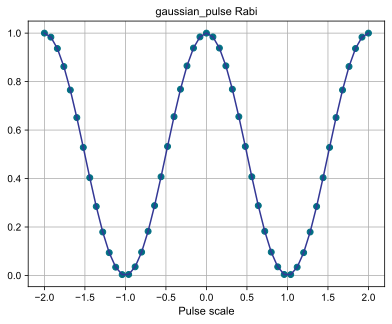

In [10]:
selective_sigma = 200 # ns

# tune selective qubit pulse using Rabi
with system.use_modes([alice]):
    with alice.temporarily_set(gaussian_pulse__sigma=selective_sigma):
        _, _, selective_qubit_amp = tune_rabi(
            system, system.fock(transmon_alice = 0, transmon_bob = 0, readout_alice =0, readout_bob=0), mode_name = alice.name,
            update = False, verify=False)

# # tune selective cavity pulse using displacement
# with system.use_modes([cavity]):
#     with cavity.temporarily_set(gaussian_pulse__sigma=selective_sigma):
#         _, _, selective_cavity_amp = tune_displacement(
#             system, cavity.fock(0), update=False, plot=False, verify=False
#         )

In [11]:
def selective_rotation(qubit, angle, phase=0, detune=0, sigma=selective_sigma):
    with qubit.gaussian_pulse.temporarily_set(sigma=sigma, amp=selective_qubit_amp):
         qubit.rotate(np.pi, phase, detune=detune)

In [12]:
init_states = [
    (f'$|g{n}\\rangle$', system.fock(transmon_alice=0, readout_alice=n)) for n in range(4)
]

In [13]:
# Apply a selective pi pulse that is resonant
# with the qubit when the cavity is in |0>.
results = {}

seq = get_sequence(system)
selective_rotation(alice, np.pi)

for label, state in tqdm(init_states, desc='Initial states'):
    result = seq.run(state)
    results[label] = result

Initial states: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


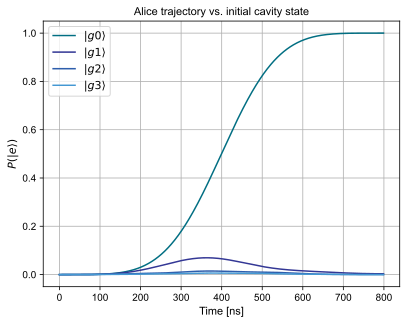

In [14]:
fig, ax = plt.subplots(1, 1)
for label, result in results.items():
    # trace over the cavity
    qubit_states = [state.ptrace(alice.index) for state in result.states]
    e_pops = qutip.expect(alice.fock_dm(1, full_space=False), qubit_states)
    ax.plot(result.times, e_pops, label=label)
    ax.grid(True)
    ax.legend(loc=0)
ax.set_xlabel('Time [ns]')
ax.set_ylabel(r'$P(|e\rangle)$')
_ = ax.set_title('Alice trajectory vs. initial cavity state')

In [59]:
bob = system.modes[0]
readout_bob = system.modes[2]
print(bob)
print(readout_bob)

Transmon(name='transmon_bob', cls='sequencing.modes.Transmon', levels=3, t1=inf, t2=inf, thermal_population=0.0, df=0.0, kerr=-0.11741838044465112, pulses={'smoothed_constant_pulse': SmoothedConstantPulse(name='smoothed_constant_pulse', cls='sequencing.pulses.SmoothedConstantPulse', amp=1.0, detune=0.0, phase=0.0, dt=1, noise_sigma=0.0, noise_alpha=0.0, scale_noise=False, length=100, sigma=0, shape='tanh'), 'gaussian_pulse': GaussianPulse(name='gaussian_pulse', cls='sequencing.pulses.GaussianPulse', amp=1.0, detune=0.0, phase=0.0, dt=1, noise_sigma=0.0, noise_alpha=0.0, scale_noise=False, sigma=10, chop=4, drag=0.0)}, default_pulse='gaussian_pulse')
Cavity(name='readout_bob', cls='sequencing.modes.Cavity', levels=10, t1=inf, t2=inf, thermal_population=0.0, df=0.0, kerr=0.003233509651516215, pulses={'smoothed_constant_pulse': SmoothedConstantPulse(name='smoothed_constant_pulse', cls='sequencing.pulses.SmoothedConstantPulse', amp=1.0, detune=0.0, phase=0.0, dt=1, noise_sigma=0.0, noise_a

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 53.76it/s]


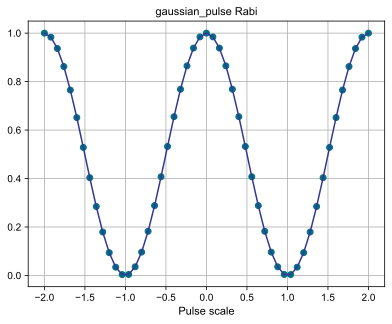

In [60]:
selective_sigma = 200 # ns

# tune selective qubit pulse using Rabi
with system.use_modes([bob]):
    with bob.temporarily_set(gaussian_pulse__sigma=selective_sigma):
        _, _, selective_qubit_amp = tune_rabi(
            system, system.fock(transmon_alice = 0, transmon_bob = 0, readout_alice =0, readout_bob=0), mode_name = bob.name,
            update = False, verify=False)


In [61]:
# Apply a selective pi pulse that is resonant
# with the qubit when the cavity is in |0>.
init_states = [
    (f'$|g{n}\\rangle$', system.fock(transmon_bob=0, readout_bob=n)) for n in range(4)
]
results = {}

seq = get_sequence(system)
selective_rotation(bob, np.pi)

for label, state in tqdm(init_states, desc='Initial states'):
    result = seq.run(state)
    results[label] = result

Initial states: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.77it/s]


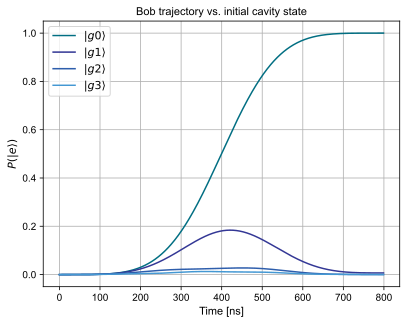

In [62]:
fig, ax = plt.subplots(1, 1)
for label, result in results.items():
    # trace over the cavity
    qubit_states = [state.ptrace(bob.index) for state in result.states]
    e_pops = qutip.expect(bob.fock_dm(1, full_space=False), qubit_states)
    ax.plot(result.times, e_pops, label=label)
    ax.grid(True)
    ax.legend(loc=0)
ax.set_xlabel('Time [ns]')
ax.set_ylabel(r'$P(|e\rangle)$')
_ = ax.set_title('Bob trajectory vs. initial cavity state')

In [83]:
def fit_exp_decay(xs, ys):
    slope, offset = np.polyfit(xs, np.log(ys), 1)
    amp = np.exp(offset)
    tau = -1 / slope
    return amp, tau

init_state = bob.fock(0) # |g> state
g_op = bob.fock_dm(0) # |g><g| operator
e_op = bob.fock_dm(1) # |e><e| operator
bob.gaussian_pulse.sigma = 15 # ns
bob.gaussian_pulse.chop = 4 # sigma

In [84]:
for delay_time in delay_times:
    Rx(pi) # excite the qubit from |g> -> |e>
    delay(delay_time)
    measure P(|e>)

SyntaxError: invalid syntax (1821229686.py, line 4)

In [122]:
tmax = 40e3 # maximum delay time, 40 us
bob.t1 = 10e3 # 10e3 ns == 10 us
seq = get_sequence(system)
# T1 sequence
bob.rotate_x(np.pi)
delay(tmax)

result = seq.run(init_state, e_ops=[g_op, e_op])

ts = result.times / 1e3 # [us]
g_pops = result.expect[0] # P(|g>)
e_pops = result.expect[1] # P(|e>)

NameError: name 'bob' is not defined

In [ ]:
# Only fit P(|e>) starting after the pi pulse is finished
t0 = bob.gaussian_pulse.sigma * bob.gaussian_pulse.chop
fit_ts = ts[t0:]
fit_amp, fit_t1 = fit_exp_decay(fit_ts, e_pops[t0:])

In [ ]:
fig, (ax, bx) = plt.subplots(1, 2, sharey=True, figsize=(9,4))
# plot population vs. time during the pi pulse
ax.plot(ts[:t0], g_pops[:t0], lw=3, label='$P(|g\\rangle)$')
ax.plot(ts[:t0], e_pops[:t0], lw=3, label='$P(|e\\rangle)$')
ax.set_title('$\pi$ pulse')

# plot population vs. time for the whole sequence
bx.plot(ts, g_pops, lw=3, label='$P(|g\\rangle)$')
bx.plot(ts, e_pops, lw=3, label='$P(|e\\rangle)$')
bx.plot(fit_ts, np.exp(-fit_ts / fit_t1), 'k--', label=f'Fit, $T_1$ = {fit_t1:.3f} $\mu$s')
bx.set_title('Full evolution')
for a in (ax, bx):
    a.set_xlabel('Time [$\mu$s]')
    a.set_ylabel('Population')
    a.grid(True)
    a.legend(loc=0)
fig.suptitle('$T_1$ sequence');

In [10]:
from qiskit_metal.analyses.quantization import LOManalysis
from qiskit_metal.analyses.quantization.lumped_capacitive import *

import pandas as pd

In [11]:
cap = pd.read_csv('cap_matrix_q1.csv').set_index('Unnamed: 0',True)
c1 = LOManalysis(elmer_renderer)

  cap = pd.read_csv('cap_matrix_q1.csv').set_index('Unnamed: 0',True)



NameError: name 'elmer_renderer' is not defined

In [125]:
c1.sim.capacitance_matrix = cap
c1.sim.capacitance_matrix


,Q1_coupler_connector_pad,via1_layer3_rectangle,Q1_pad_top,Q1_pad_bot,ground_plane
Unnamed: 0,,,,,
Q1_coupler_connector_pad,115.428853,-0.085191,-19.976788,-1.526316,-93.840558
via1_layer3_rectangle,-0.085191,183.042456,-1.991526,-27.695974,-153.269765
Q1_pad_top,-19.976788,-1.991526,237.324094,-51.770234,-163.585546
Q1_pad_bot,-1.526316,-27.695974,-51.770234,241.653123,-160.660598
ground_plane,-93.840558,-153.269765,-163.585546,-160.660598,300.000000


In [126]:
c1.run_lom()
c1.lumped_oscillator

AttributeError: 'int' object has no attribute 'items'

TypeError: extract_transmon_coupled_Noscillator() missing 5 required positional arguments: 'Ic', 'CJ', 'N', 'fb', and 'fr'

-3.018103370375667e-18